In [36]:
### import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from utils import seir, modified_seir

# Models

## SEIR Model
A basic SEIR model was used to simulate the spread of an infectious disease in a population that was not vaccinated. Note that we used normalized variables such that the total population $N = S + E + I + R = 1$.

### Equations
$$\dot{S} = - \beta S I$$
$$\dot{E}= \beta S I - \sigma E$$
$$\dot{I} = \sigma E - \gamma I$$
$$\dot{R} = \gamma I$$

### Variables
- $S$: Fraction of susceptible individuals
- $E$: Fraction of exposed individuals
- $I$: Fraction of infected individuals
- $R$: Fraction of recovered individuals

### Parameters
- $\beta$: Rate at which infected individuals in class $I$ contact susceptible individuals and infect them
- $\sigma$: Rate at which susceptible individuals in class $S$ progress to the exposed population
- $\gamma$: Rate at which infected individuals in class $I$ recover from the disease and become immune

## Modified SEIR Model
We modified the above SEIR model to investigate two possible vaccine failure mechanisms - 'leaky' and 'all-or-nothing'. Note that similar to the SEIR Model above, all variables used were normalized such that $N = S + V_{ES} + V_{RS} + E + I + R = 1$.

### Equations
$$\dot{S} = - \beta SI - (1 - \frac{V_{ES} + V_{RS}}{v})fS$$
$$\dot{V}_{ES} = (1 - \epsilon_A)(1 - \frac{V_{ES} + V_{RS}}{v})fS - \beta V_{ES}I$$
$$\dot{V}_{RS} = (1 - \frac{V_{ES} + V_{RS}}{v})fS\epsilon_A - (1-\epsilon_L)\beta V_{RS}I$$
$$\dot{E} = \beta SI + \beta V_{ES}I + (1 - \epsilon_L)\beta V_{RS}I - \sigma E$$
$$\dot{I} = \sigma E - \gamma I$$
$$\dot{R} = \gamma I$$

### Variables
- $S$: Fraction of susceptible and uninfected individuals
- $V_{ES}$: Fraction of vaccinated and uninfected individuals who are equally as susceptible as unvaccinated individuals 
- $V_{RS}$: Fraction of vaccinated and uninfected individuals who are less susceptible than unvaccinated individuals
- $E$: Fraction of exposed individuals who are not yet infected
- $I$: Fraction of infected individuals
- $R$: Fraction of recovered individuals

### Parameters
- $\beta$: Rate at which infected individuals in class $I$ contact susceptible individuals and infect them
- $v$: Maximum fraction of population to be vaccinated
- $f(t)$: Vaccination rate at time t
- $\epsilon_A$: 'All-or-nothing' vaccine efficacy
- $\epsilon_L$: 'Leaky' vaccine efficacy
- $\sigma$: Rate at which susceptible individuals in class $S$ progress to the exposed population
- $\gamma$: Rate at which infected individuals in class $I$ recover from the disease and become immune

## Basic Reproduction Number ($R_0$)

The basic reproduction number $R_0$ is defined as the average number of secondary cases produced by a single infected individual. This dimensionless number can be calculated by dividing the transmission rate of the disease by its recovery rate, as it represents the ratio of how fast the disease spreads to the expected duration of infection. 

$$ R_0 = \frac{\beta N}{\gamma} $$

The $R_0$ value changes throughout the progression of the disease as interventions that lower the transmission rate are introduced, such as vaccination or quarantine. Note that the $R_0$ value used in these simulations is the value before any interventions are implemented, and we assume $N=1$ because the variables are normalized. 


# Time-Series Plots

## Pre-transmission Vaccination
We will assume that vaccination happens all at once for simplicity. Note that for a leaky vaccine, $\epsilon_A = 1$, and for an all-or-nothing vaccine, $\epsilon_L = 1$.

For the plots below, $\beta, \gamma, \sigma$ values were chosen based on the characteristics of COVID-19, and $\epsilon_L, \epsilon_A, v$ were arbitrary values that show the difference between the two vaccine failure mechanisms.

In [24]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2*gamma; f = 0; vmax = 0.5
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; t = np.arange(0, 200)
s0_vax = 0.98-vmax; e0_vax = 0.01; i0_vax = 0.01

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# leaky
epsL = 0.5; epsA = 1; 
v_es0_leaky = 0; v_rs0_leaky = vmax; y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0_vax, i0_vax, r0
sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T
vtot_leaky = v_es_leaky + v_rs_leaky

# all-or-nothing
epsL = 1; epsA = 0.5; 
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA; y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0_vax, i0_vax, r0
sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T
vtot_aon = v_es_aon + v_rs_aon

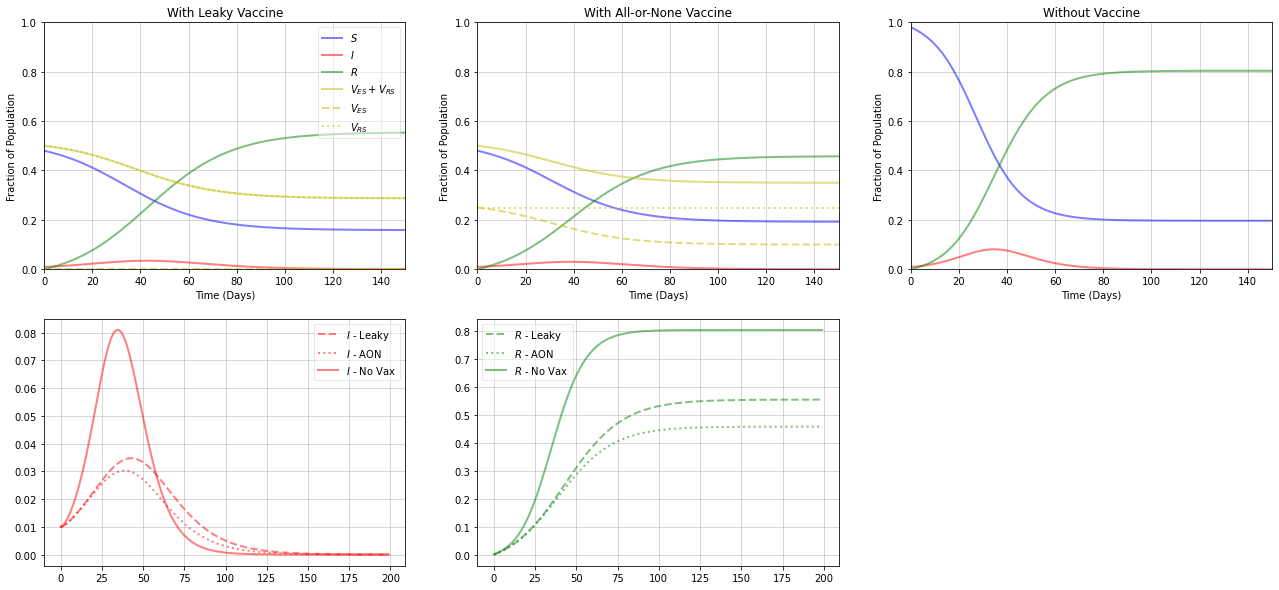

In [25]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,10))

ax1 = fig.add_subplot(231, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(loc='upper right'); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(232, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(233, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

ax4 = fig.add_subplot(234, axisbelow=True)
ax4.plot(t, i_leaky, 'r--', alpha=0.5, lw=2, label='$I$ - Leaky')
ax4.plot(t, i_aon, 'r:', alpha=0.5, lw=2, label= '$I$ - AON')
ax4.plot(t, i, 'r', alpha=0.5, lw=2, label='$I$ - No Vax')
ax4.grid(linewidth=0.5)
legend = ax4.legend(); legend.get_frame().set_alpha(0.5)

ax5 = fig.add_subplot(235, axisbelow=True)
ax5.plot(t, r_leaky, 'g--', alpha=0.5, lw=2, label='$R$ - Leaky')
ax5.plot(t, r_aon, 'g:', alpha=0.5, lw=2, label='$R$ - AON')
ax5.plot(t, r, 'g', alpha=0.5, lw=2, label='$R$ - No Vax')
ax5.grid(linewidth=0.5)
legend = ax5.legend(); legend.get_frame().set_alpha(0.5)

#plt.savefig('seir_example', bbox_inches='tight')

## 10 Days Post-transmission Vaccination

In [6]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2*gamma; f = 0; vmax = 0.5
s0 = 0.98; v_es0 = 0; v_rs0 = 0; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; 
D = 150; D_vax = 10; t = np.arange(0, D+1)

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# vaccination
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)
sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

# leaky
epsL = 0.5; epsA = 1
v_es0_leaky = 0; v_rs0_leaky = vmax
y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_leaky, v_es1_leaky, v_rs1_leaky, e1_leaky, i1_leaky, r1_leaky = sim_leaky.T
vtot1_leaky = v_es1_leaky + v_rs1_leaky

s_leaky = np.concatenate((s0_vax[:-1], s1_leaky), axis=None)
e_leaky = np.concatenate((e0_vax[:-1], e1_leaky), axis=None)
i_leaky = np.concatenate((i0_vax[:-1], i1_leaky), axis=None)
r_leaky = np.concatenate((r0_vax[:-1], r1_leaky), axis=None)
vtot_leaky = np.concatenate((np.zeros(D_vax), vtot1_leaky), axis=None)
v_es_leaky = np.concatenate((np.zeros(D_vax), v_es1_leaky), axis=None)
v_rs_leaky = np.concatenate((np.zeros(D_vax), v_rs1_leaky), axis=None)

# aon
epsL = 1; epsA = 0.5
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_aon, v_es1_aon, v_rs1_aon, e1_aon, i1_aon, r1_aon = sim_aon.T
vtot1_aon = v_es1_aon + v_rs1_aon

s_aon = np.concatenate((s0_vax[:-1], s1_aon), axis=None)
e_aon = np.concatenate((e0_vax[:-1], e1_aon), axis=None)
i_aon = np.concatenate((i0_vax[:-1], i1_aon), axis=None)
r_aon = np.concatenate((r0_vax[:-1], r1_aon), axis=None)
vtot_aon = np.concatenate((np.zeros(D_vax), vtot1_aon), axis=None)
v_es_aon = np.concatenate((np.zeros(D_vax), v_es1_aon), axis=None)
v_rs_aon = np.concatenate((np.zeros(D_vax), v_rs1_aon), axis=None)

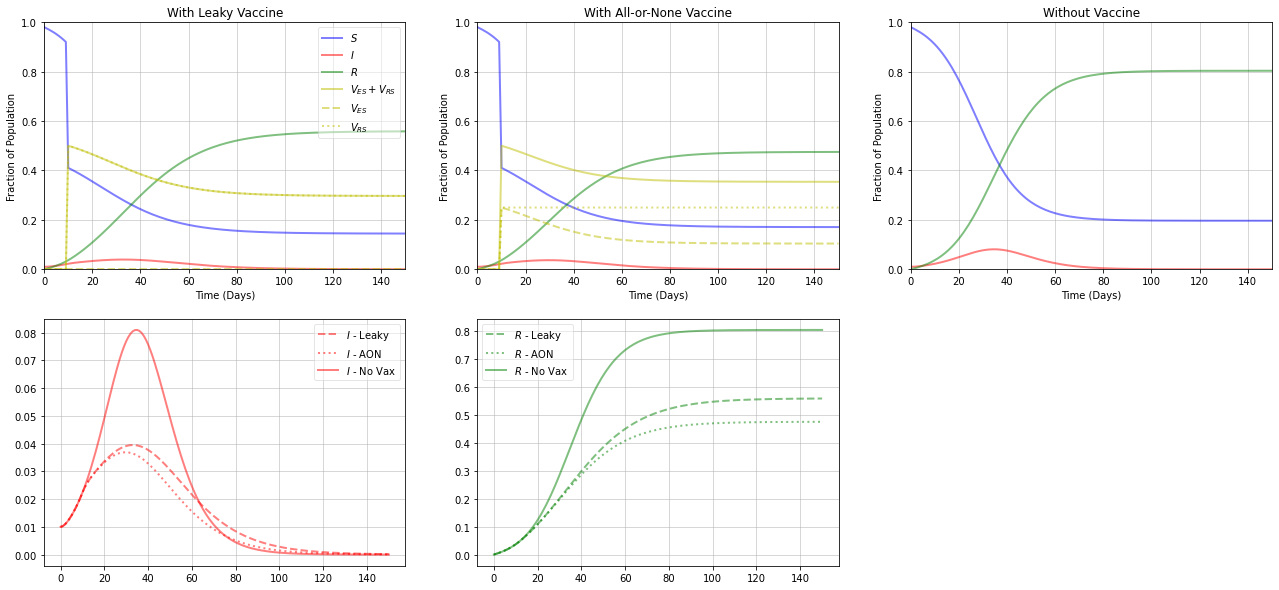

In [20]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22, 10))

ax1 = fig.add_subplot(231, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(loc='upper right'); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(232, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(233, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

ax4 = fig.add_subplot(234, axisbelow=True)
ax4.plot(t, i_leaky, 'r--', alpha=0.5, lw=2, label='$I$ - Leaky')
ax4.plot(t, i_aon, 'r:', alpha=0.5, lw=2, label= '$I$ - AON')
ax4.plot(t, i, 'r', alpha=0.5, lw=2, label='$I$ - No Vax')
ax4.grid(linewidth=0.5)
legend = ax4.legend(); legend.get_frame().set_alpha(0.5)

ax5 = fig.add_subplot(235, axisbelow=True)
ax5.plot(t, r_leaky, 'g--', alpha=0.5, lw=2, label='$R$ - Leaky')
ax5.plot(t, r_aon, 'g:', alpha=0.5, lw=2, label='$R$ - AON')
ax5.plot(t, r, 'g', alpha=0.5, lw=2, label='$R$ - No Vax')
ax5.grid(linewidth=0.5)
legend = ax5.legend(); legend.get_frame().set_alpha(0.5)

#plt.savefig('seir_example', bbox_inches='tight')

## 30 Days Post-Transmission Vaccination

In [26]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2*gamma; f = 0; vmax = 0.5
s0 = 0.98; v_es0 = 0; v_rs0 = 0; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; 
D = 200; D_vax = 30; t = np.arange(0, D+1)

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# vaccination
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)
sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

# leaky
epsL = 0.5; epsA = 1
v_es0_leaky = 0; v_rs0_leaky = vmax
y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_leaky, v_es1_leaky, v_rs1_leaky, e1_leaky, i1_leaky, r1_leaky = sim_leaky.T
vtot1_leaky = v_es1_leaky + v_rs1_leaky

s_leaky = np.concatenate((s0_vax[:-1], s1_leaky), axis=None)
e_leaky = np.concatenate((e0_vax[:-1], e1_leaky), axis=None)
i_leaky = np.concatenate((i0_vax[:-1], i1_leaky), axis=None)
r_leaky = np.concatenate((r0_vax[:-1], r1_leaky), axis=None)
vtot_leaky = np.concatenate((np.zeros(D_vax), vtot1_leaky), axis=None)
v_es_leaky = np.concatenate((np.zeros(D_vax), v_es1_leaky), axis=None)
v_rs_leaky = np.concatenate((np.zeros(D_vax), v_rs1_leaky), axis=None)

# aon
epsL = 1; epsA = 0.5
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_aon, v_es1_aon, v_rs1_aon, e1_aon, i1_aon, r1_aon = sim_aon.T
vtot1_aon = v_es1_aon + v_rs1_aon

s_aon = np.concatenate((s0_vax[:-1], s1_aon), axis=None)
e_aon = np.concatenate((e0_vax[:-1], e1_aon), axis=None)
i_aon = np.concatenate((i0_vax[:-1], i1_aon), axis=None)
r_aon = np.concatenate((r0_vax[:-1], r1_aon), axis=None)
vtot_aon = np.concatenate((np.zeros(D_vax), vtot1_aon), axis=None)
v_es_aon = np.concatenate((np.zeros(D_vax), v_es1_aon), axis=None)
v_rs_aon = np.concatenate((np.zeros(D_vax), v_rs1_aon), axis=None)

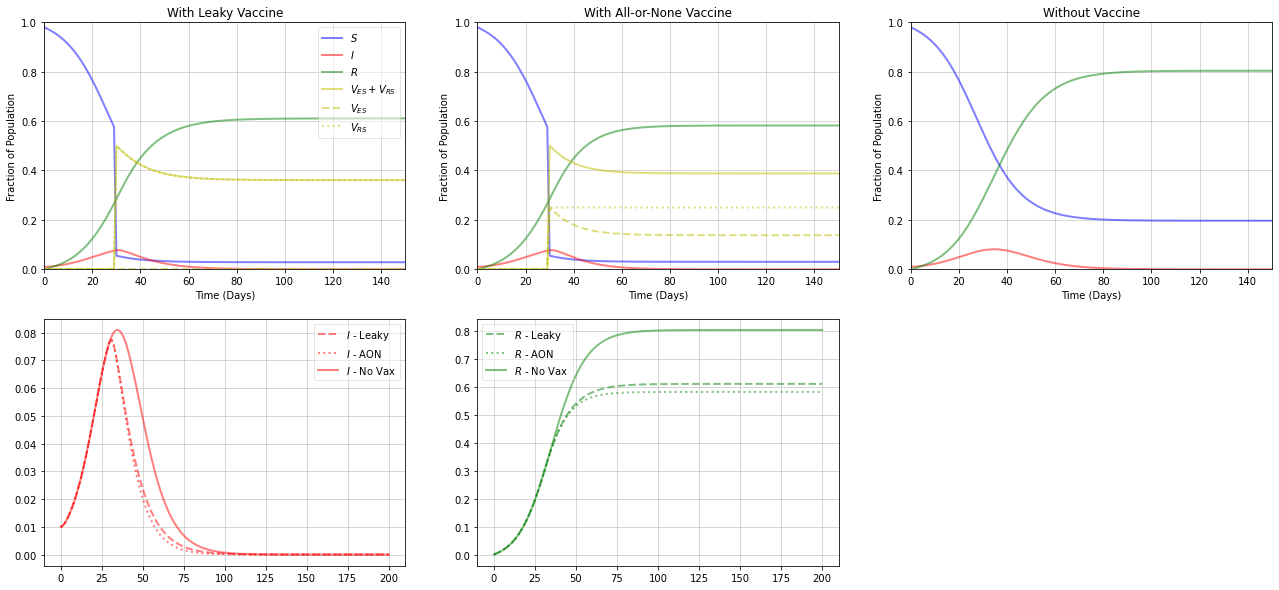

In [27]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,10))

ax1 = fig.add_subplot(231, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(loc='upper right'); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(232, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(233, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

ax4 = fig.add_subplot(234, axisbelow=True)
ax4.plot(t, i_leaky, 'r--', alpha=0.5, lw=2, label='$I$ - Leaky')
ax4.plot(t, i_aon, 'r:', alpha=0.5, lw=2, label= '$I$ - AON')
ax4.plot(t, i, 'r', alpha=0.5, lw=2, label='$I$ - No Vax')
ax4.grid(linewidth=0.5)
legend = ax4.legend(); legend.get_frame().set_alpha(0.5)

ax5 = fig.add_subplot(235, axisbelow=True)
ax5.plot(t, r_leaky, 'g--', alpha=0.5, lw=2, label='$R$ - Leaky')
ax5.plot(t, r_aon, 'g:', alpha=0.5, lw=2, label='$R$ - AON')
ax5.plot(t, r, 'g', alpha=0.5, lw=2, label='$R$ - No Vax')
ax5.grid(linewidth=0.5)
legend = ax5.legend(); legend.get_frame().set_alpha(0.5)

#plt.savefig('seir_example', bbox_inches='tight')

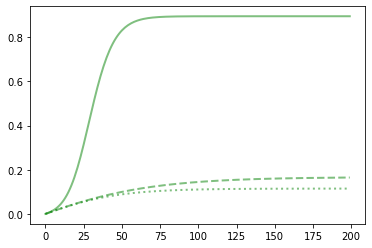

In [34]:
### run model - Below V_c
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2.5*gamma; f = 0; hit_val = (1 - 1/2.5) / 0.6; vmax = 1 - ((1 - hit_val) * 0.8)
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; t = np.arange(0, 200)
s0_vax = 0.98-vmax; e0_vax = 0.01; i0_vax = 0.01

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r_pre_slabove = sim.T

# leaky
epsL = 0.6; epsA = 1; 
v_es0_leaky = 0; v_rs0_leaky = vmax; y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0_vax, i0_vax, r0
sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky_pre_slabove = sim_leaky.T
vtot_leaky = v_es_leaky + v_rs_leaky

# all-or-nothing
epsL = 1; epsA = 0.6; 
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA; y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0_vax, i0_vax, r0
sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon_pre_slabove = sim_aon.T
vtot_aon = v_es_aon + v_rs_aon

plt.plot(t, r_pre_slabove, 'g', alpha=0.5, lw=2)
plt.plot(t, r_leaky_pre_slabove, 'g--', alpha=0.5, lw=2)
plt.plot(t, r_aon_pre_slabove, 'g:', alpha=0.5, lw=2)

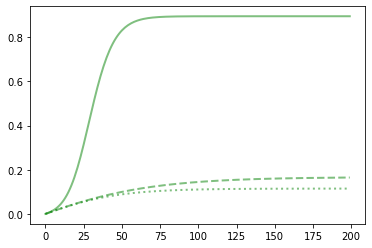

In [35]:
### run model - Below V_c
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2.5*gamma; f = 0; hit_val = (1 - 1/2.5) / 0.6; vmax = 1 - ((1 - hit_val) * 0.5)
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; t = np.arange(0, 200)
s0_vax = 0.98-vmax; e0_vax = 0.01; i0_vax = 0.01

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r_pre_above = sim.T

# leaky
epsL = 0.6; epsA = 1; 
v_es0_leaky = 0; v_rs0_leaky = vmax; y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0_vax, i0_vax, r0
sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky_pre_above = sim_leaky.T
vtot_leaky = v_es_leaky + v_rs_leaky

# all-or-nothing
epsL = 1; epsA = 0.6; 
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA; y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0_vax, i0_vax, r0
sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon_pre_above = sim_aon.T
vtot_aon = v_es_aon + v_rs_aon

plt.plot(t, r_pre_above, 'g', alpha=0.5, lw=2)
plt.plot(t, r_leaky_pre_above, 'g--', alpha=0.5, lw=2)
plt.plot(t, r_aon_pre_above, 'g:', alpha=0.5, lw=2)

## Conclusion

